<h3>Neural network, Data generation</h3>

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# just copy/paste -the needed activation functions, 
# we're going to need these again

# activation functions
# ReLu is very simple, it filters out all negative numbers
# this is a powerful activation function in reality
def activation_ReLu(number):
    if number > 0:
        return number
    else:
        return 0
    
# we also need a derived version of ReLu later
# otherwise the same than original, but instead of original value
# return 1 instead
def activation_ReLu_partial_derivative(number):
    if number > 0:
        return 1
    else:
        return 0

In [68]:
def generate_train_data(num_rows=2000, seed=123):
    """
    Generates training data with a mix of uniform and normal distributions for realism.
    Args:
        num_rows (int): Number of rows to generate.
        seed (int): Random seed for reproducibility.
    Returns:
        list: A list of [x1, x2, y] rows.
    """
    # Lock randomness for reproducibility
    np.random.seed(seed)
    
    result = []
    
    for _ in range(num_rows):
        # Generate features using a mix of distributions
        x1 = np.random.normal(loc=5, scale=2)  # Normally distributed around 5 with std 2
        x2 = np.random.uniform(5, 15)          # Uniform distribution between 5 and 15
        
        # Clip x1 to keep values within a reasonable range
        x1 = max(0, min(10, x1))  # Ensure x1 stays between 0 and 10
        
        # Add additional variability in the target variable (y)
        noise = np.random.normal(loc=0, scale=3)  # Gaussian noise with mean 0 and std 3
        y = x1 ** 2 + x2 + noise
        
        # Append the row to the result
        result.append([x1, x2, y])
    
    return result

<b>The neural network training code</b>

In [69]:
# we'll start building our neural network training app here
# initialize weights and biases
# in Keras etc. these are usually randomized in the beginning
w1 = 1.5
w2 = 0.5
w3 = -2
w4 = -0.5
w5 = 1.5
w6 = 1.2
bias1 = 0.5
bias2 = -0.35
bias3 = 0.1

# we'll save these for future
# se we can compare results to the final weights
original_w1 = w1
original_w2 = w2
original_w3 = w3
original_w4 = w4
original_w5 = w5
original_w6 = w6
original_b1 = bias1
original_b2 = bias2
original_b3 = bias3
 
# learning rate and epochs
LR = 0.005
epochs = 500

# Regularization strength for both weights and biases
regularization_strength = 0.025

# override above data with our generation function
data = generate_train_data()

# let's initialize a list for loss points
loss_points = []

# START THE TRAINING PROCESS
for epoch in range(epochs):

    # let's also monitor epoch-wise losses
    epoch_losses = []

    for row in data:
        # for example with first row
        # [1, 0, 2] => assign input1 = 1, input2 = 0, true_value = 2
        input1 = row[0]
        input2 = row[1]
        true_value = row[2]

        # FORWARD PASS

        # NODE 1 OUTPUT
        node_1_output = input1 * w1 + input2 * w3 + bias1
        node_1_output = activation_ReLu(node_1_output)

        # NODE 2 OUTPUT
        node_2_output = input1 * w2 + input2 * w4 + bias2
        node_2_output = activation_ReLu(node_2_output)

        # NODE 3 OUTPUT
        # we can just use Node 1 and 2 outputs, since they
        # already contain the the previous weights
        node_3_output = node_1_output * w5 + node_2_output * w6 + bias3
        node_3_output = activation_ReLu(node_3_output)

        # probably used later, we might want to have error metrics (MSE)
        predicted_value = node_3_output

        # LOSS CALCULATION WITH REGULARIZATION
        loss = (predicted_value - true_value) ** 2
        loss += regularization_strength * (w1**2 + w2**2 + w3**2 + w4**2 + w5**2 + w6**2)  # Weight decay
        loss += regularization_strength * (bias1**2 + bias2**2 + bias3**2)  # Bias penalty
      
        # add current training data row loss to epoch losses
        epoch_losses.append(loss)

        # BACKPROPAGATION - LAST LAYER FIRST
        # solve w5 and update the new value
        deriv_L_w5 = 2 * node_1_output * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_w5 = w5 - LR * deriv_L_w5

        # solve w6 and update the new value
        deriv_L_w6 = 2 * node_2_output * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_w6 = w6 - LR * deriv_L_w6

        # solve bias3 and update the new value
        deriv_L_b3 = 2 * 1 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_b3 = bias3 - LR * deriv_L_b3

        # BACKPROPAGATION - THE FIRST LAYER
        # FROM THIS POINT FORWARD WE HAVE TO USE THE MORE COMPLEX VERSION
        # OF UPDATING THE VALUES -> CHAIN RULE

        # see the materials and the math experiment notebook for more details
        # start with weight 1
        deriv_L_w1_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w1_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * input1
        deriv_L_w1 = deriv_L_w1_left * deriv_L_w1_right
        new_w1 = w1 - LR * deriv_L_w1

        # weight 2
        deriv_L_w2_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w2_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * input1
        deriv_L_w2 = deriv_L_w2_left * deriv_L_w2_right
        new_w2 = w2 - LR * deriv_L_w2

        # weight 3
        deriv_L_w3_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w3_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * input2
        deriv_L_w3 = deriv_L_w3_left * deriv_L_w3_right
        new_w3 = w3 - LR * deriv_L_w3

        # weight 4
        deriv_L_w4_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w4_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * input2
        deriv_L_w4 = deriv_L_w4_left * deriv_L_w4_right
        new_w4 = w4 - LR * deriv_L_w4

        # bias 1
        deriv_L_b1_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_b1_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * 1
        deriv_L_b1 = deriv_L_b1_left * deriv_L_b1_right
        new_b1 = bias1 - LR * deriv_L_b1

        # bias 2
        deriv_L_b2_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_b2_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * 1
        deriv_L_b2 = deriv_L_b2_left * deriv_L_b2_right
        new_b2 = bias2 - LR * deriv_L_b2

        # ALL DONE! FINALLY UPDATE THE EXISTING WEIGHTS!
        w1 = new_w1
        w2 = new_w2
        w3 = new_w3
        w4 = new_w4
        w5 = new_w5
        w6 = new_w6
        bias1 = new_b1
        bias2 = new_b2
        bias3 = new_b3

    # calculate average epoch-wise loss and add it the loss_points
    average_loss = sum(epoch_losses) / len(epoch_losses)

    # place the average loss of this epoch into the overall loss list
    loss_points.append(average_loss)
    print(f"Epoch: {epoch +1}, loss {loss}")

Epoch: 1, loss 1469.7744571915914
Epoch: 2, loss 1469.7744621319648
Epoch: 3, loss 1469.7744621319648
Epoch: 4, loss 1469.7744621319648
Epoch: 5, loss 1469.7744621319648
Epoch: 6, loss 1469.7744621319648
Epoch: 7, loss 1469.7744621319648
Epoch: 8, loss 1469.7744621319648
Epoch: 9, loss 1469.7744621319648
Epoch: 10, loss 1469.7744621319648
Epoch: 11, loss 1469.7744621319648
Epoch: 12, loss 1469.7744621319648
Epoch: 13, loss 1469.7744621319648
Epoch: 14, loss 1469.7744621319648
Epoch: 15, loss 1469.7744621319648
Epoch: 16, loss 1469.7744621319648
Epoch: 17, loss 1469.7744621319648
Epoch: 18, loss 1469.7744621319648
Epoch: 19, loss 1469.7744621319648
Epoch: 20, loss 1469.7744621319648
Epoch: 21, loss 1469.7744621319648
Epoch: 22, loss 1469.7744621319648
Epoch: 23, loss 1469.7744621319648
Epoch: 24, loss 1469.7744621319648
Epoch: 25, loss 1469.7744621319648
Epoch: 26, loss 1469.7744621319648
Epoch: 27, loss 1469.7744621319648
Epoch: 28, loss 1469.7744621319648
Epoch: 29, loss 1469.77446213

In [70]:
print("ORIGINAL WEIGHTS AND BIASES")
print(f"w1: {original_w1}")
print(f"w2: {original_w2}")
print(f"w3: {original_w3}")
print(f"w4: {original_w4}")
print(f"w5: {original_w5}")
print(f"w6: {original_w6}")
print(f"b1: {original_b1}")
print(f"b2: {original_b2}")
print(f"b3: {original_b3}")

print("\n\n######################################")

print("NEW WEIGHTS AND BIASES")
print(f"w1: {w1}")
print(f"w2: {w2}")
print(f"w3: {w3}")
print(f"w4: {w4}")
print(f"w5: {w5}")
print(f"w6: {w6}")
print(f"b1: {bias1}")
print(f"b2: {bias2}")
print(f"b3: {bias3}")



ORIGINAL WEIGHTS AND BIASES
w1: 1.5
w2: 0.5
w3: -2
w4: -0.5
w5: 1.5
w6: 1.2
b1: 0.5
b2: -0.35
b3: 0.1


######################################
NEW WEIGHTS AND BIASES
w1: -22.57879330308162
w2: 0.6993718191591087
w3: -24.56428517171817
w4: -7.2208363119949786
w5: -125.79115347161417
w6: -75.69495229790346
b1: -2.7310162755341576
b2: -0.7294230413757751
b3: 39.238939622948


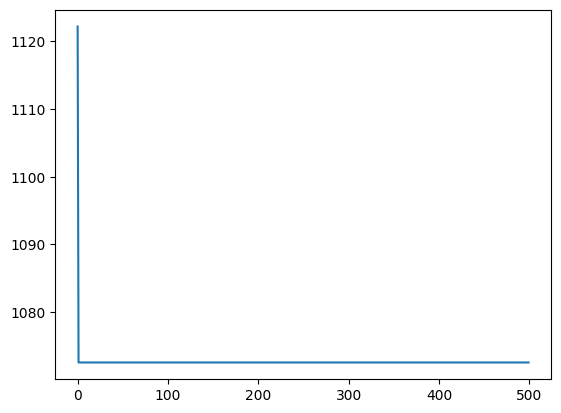

In [71]:
plt.plot(loss_points)
plt.show()

In [72]:
# prediction function, just doing the forward pass
# again (but only that)
def predict(x1, x2):
    input1 = x1
    input2 = x2

    # FORWARD PASS

    # NODE 1 OUTPUT
    node_1_output = input1 * w1 + input2 * w3 + bias1
    node_1_output = activation_ReLu(node_1_output)

    # NODE 2 OUTPUT
    node_2_output = input1 * w2 + input2 * w4 + bias2
    node_2_output = activation_ReLu(node_2_output)

    # NODE 3 OUTPUT
    # we can just use Node 1 and 2 outputs, since they
    # already contain the the previous weights
    node_3_output = node_1_output * w5 + node_2_output * w6 + bias3
    node_3_output = activation_ReLu(node_3_output)

    return node_3_output

In [73]:
data[0]

[2.8287387933988777, 7.268514535642031, 18.262314036672528]

In [74]:
data[15]

[5.027077098262832, 11.128945257629677, 37.41257177726149]

In [75]:
 # the value tends to be same as final bias3 
# so if node1 and node2 outputs are small => more or less bias3
result = predict(0.03846154, 0.23076923)
result

39.238939622948

In [76]:
# the value tends to be same as final bias3 
# so if node1 and node2 outputs are small => more or less bias3
predict(1, 4)

39.238939622948

In [77]:
predict(30,150)

39.238939622948